In [113]:
import os
import pickle
import numpy as np
from tqdm import tqdm

root = 'data'
saved_file = 'features_cache.pkl'

# 載入已經存的資料
if os.path.exists(saved_file):
    print("Loading saved features...")
    with open(saved_file, 'rb') as f:
        data = pickle.load(f)
    features = data['features']
    name = data['name']
    loaded_names = set(name)
else:
    features = []
    name = []
    loaded_names = set()

# 讀取新資料夾
for subdir_entry in os.scandir(root):
    if not subdir_entry.is_dir():
        continue
    subdir_path = os.path.join(subdir_entry.path, 'KEYPOINT_DIR')
    if not os.path.exists(subdir_path):
        continue

    try:
        for f_entry in os.scandir(subdir_path):
            if not f_entry.is_dir():
                continue

            if f_entry.path in loaded_names:
                continue

            feature = []
            npy_files = sorted([
                entry.path for entry in os.scandir(f_entry.path)
                if entry.is_file() and entry.name.endswith('.npy')
            ])
            for npy_path in tqdm(npy_files, desc=f"Loading {f_entry.name}"):
                feature.append(np.load(npy_path, allow_pickle=False))
            if feature:
                features.append(np.array(feature))
                name.append(f_entry.path)
                loaded_names.add(f_entry.path)

    except Exception as e:
        print(f"Skipping {subdir_entry.name} due to error: {e}")

# 保存到 pickle
with open(saved_file, 'wb') as f:
    pickle.dump({'features': features, 'name': name}, f)

print(f"Saved features to {saved_file}")


Loading saved features...


Loading pitch_0070: 100%|██████████| 51/51 [00:00<00:00, 115.17it/s]


Saved features to features_cache.pkl


In [116]:
import json
from pose_utils_detectron2 import load_pose_sequence
from pose_detectron2 import run_detectron2

from detect_release import detect_release
from detect_landing import detect_landing
from detect_shoulder import detect_shoulder

from landing_features import detect_landing_features
from shoulder_features import extract_shoulder_features
from release_features import extract_release_features

batch_X = []
for sequence in features:
    single_X = []
    pose_sequence = [{'frame': i, 'keypoints': sequence[i]} for i in range(sequence.shape[0])]
    release_frame = detect_release(pose_sequence)
    if release_frame == None:
        release_frame = 0
    try:
        landing_frame = detect_landing(pose_sequence, release_frame)
    except:
        landing_frame = 0
    try:
        shoulder_frame = detect_shoulder(pose_sequence, release_frame)
    except:
        shoulder_frame = 0
    landing_features = detect_landing_features(pose_sequence, landing_frame)
    for key, value in landing_features.items():
        single_X.append(value)
    shoulder_features = extract_shoulder_features(
        pose_sequence, shoulder_frame, landing_frame
    )
    for key, value in shoulder_features.items():
        single_X.append(value)
        
    release_features = extract_release_features(pose_sequence, release_frame)
    for key, value in release_features.items():
        single_X.append(value)
    batch_X.append(single_X)
batch_X

0 : 617.8670806884766 709.1404418945312 562.3709716796875
1 : 0.0 709.2615966796875 709.2615966796875
出手條件不滿足
2 : 0.0 709.610107421875 709.610107421875
出手條件不滿足
3 : 0.0 708.9744873046875 708.9744873046875
出手條件不滿足
4 : 687.8191070556641 708.6708984375 708.6708984375
出手條件不滿足
5 : 689.0333404541016 708.3779296875 708.3779296875
出手條件不滿足
6 : 84.4127197265625 712.283203125 564.5658569335938
7 : 688.8334503173828 709.0789184570312 709.0789184570312
出手條件不滿足
8 : 98.781982421875 709.13916015625 563.2216186523438
9 : 97.85601806640625 710.0344848632812 562.2627563476562
10 : 93.12591552734375 709.0277099609375 562.3456420898438
11 : 68.16119384765625 710.383544921875 565.4674682617188
12 : 71.994384765625 710.6286010742188 567.7152709960938
13 : 86.42034912109375 709.5765380859375 562.8424072265625
14 : 72.951416015625 712.6922607421875 566.844482421875
15 : 71.9835205078125 709.9110717773438 572.6346435546875
16 : 85.4501953125 712.671875 564.8535766601562
17 : 489.63507080078125 711.1240844726562 

出手條件不滿足
125 : 19.07196044921875 592.3331298828125 465.0778503417969
出手條件不滿足
126 : 19.139617919921875 592.2969360351562 464.9111633300781
出手條件不滿足
127 : 20.106231689453125 591.8607788085938 465.1416015625
出手條件不滿足
128 : 18.176483154296875 594.6423950195312 464.21282958984375
出手條件不滿足
129 : 19.199188232421875 590.2775268554688 463.6932373046875
出手條件不滿足
130 : 21.05615234375 598.6244506835938 463.4239807128906
出手條件不滿足
131 : 20.004119873046875 587.1371459960938 462.7994384765625
出手條件不滿足
132 : 19.129730224609375 582.7451782226562 462.8689880371094
出手條件不滿足
133 : 19.096343994140625 584.017578125 462.3903503417969
出手條件不滿足
134 : 19.152099609375 592.8713989257812 462.3257751464844
出手條件不滿足
135 : 18.243072509765625 592.5630493164062 461.45916748046875
出手條件不滿足
136 : 19.168914794921875 589.169189453125 462.4807434082031
出手條件不滿足
137 : 20.97113037109375 590.0770874023438 462.8558044433594
出手條件不滿足
138 : 20.160400390625 593.0205078125 461.9069519042969
出手條件不滿足
139 : 21.013275146484375 592.1177978515625 462.

[[13,
  90.0,
  0.0,
  1.1503662761676192,
  126.1,
  0.0,
  2.53,
  97.6,
  178.7,
  34.55,
  0.61],
 [0,
  15.435509895281923,
  0.0,
  89.72552544257822,
  56.6,
  1.7,
  1.96,
  125.2,
  2.5,
  11.51,
  2.55],
 [1, 90.0, 0.0, 90.0, 8.8, 0.0, 6.62, 91.0, 176.0, 43.0, 0.51],
 [30,
  21.614192861981756,
  0.0,
  98.79697218835425,
  59.9,
  9.8,
  0.4,
  159.3,
  174.2,
  5.31,
  1.28],
 [9,
  14.318769394688918,
  0.957275390625,
  102.38250754029224,
  55.6,
  19.4,
  0.44,
  39.9,
  0.2,
  3.4,
  0.35],
 [0,
  0.0026403443843977374,
  0.0,
  90.0,
  24.8,
  45.8,
  0.17,
  75.3,
  179.7,
  7.53,
  0.1],
 [2,
  5.8797685437697,
  23.008010864257812,
  113.82965549833621,
  65.6,
  62.2,
  1.62,
  132.0,
  22.4,
  2.2,
  0.69],
 [77,
  31.288462390414175,
  0.0,
  9.13042472640602,
  66.9,
  49.2,
  1.32,
  42.4,
  172.7,
  56.16,
  0.98],
 [0,
  16.769673237704115,
  228.27694702148438,
  106.46397024376701,
  50.3,
  104.8,
  0.46,
  51.0,
  26.3,
  6.27,
  0.85],
 [16,
  48.938020

In [118]:
np.array(batch_X).shape

(70, 11)

In [119]:
import os
import pandas as pd
from tqdm import tqdm

# Step1: 先找到所有球員 CSV，讀取並合併成一個大 DataFrame
csv_cache = {}

for j in name:
    parts = j.split(os.sep)
    player_folder = parts[1]
    player_name = player_folder.replace("_videos_4S", "")
    csv_path = os.path.join('data', player_folder, f"{player_name}.csv")
    if csv_path not in csv_cache and os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        # 建立映射 key 是影片小寫檔名，value 是 description
        csv_cache[csv_path] = {k.lower(): v for k, v in zip(df['Filename'], df['description'])}

# Step2: 用 cache 查詢 label，速度會快很多
y = []
for j in tqdm(name):
    parts = j.split(os.sep)
    player_folder = parts[1]
    video_name = parts[-1] + '.mp4'
    player_name = player_folder.replace("_videos_4S", "")
    csv_path = os.path.join('data', player_folder, f"{player_name}.csv")

    if csv_path in csv_cache:
        label = csv_cache[csv_path].get(video_name.lower(), 'Unknown')
    else:
        label = 'Unknown'

    y.append(label)

# 測試輸出
for i, label in zip(features, y):
    print(i.shape, label)


100%|██████████| 70/70 [00:00<00:00, 236584.43it/s]

(153, 17, 3) ball
(151, 17, 3) foul
(10, 17, 3) hit_into_play
(69, 17, 3) hit_into_play
(238, 17, 3) ball
(98, 17, 3) foul
(32, 17, 3) foul
(138, 17, 3) called_strike
(49, 17, 3) ball
(89, 17, 3) ball
(120, 17, 3) called_strike
(82, 17, 3) ball
(105, 17, 3) ball
(103, 17, 3) foul
(5, 17, 3) ball
(238, 17, 3) ball
(30, 17, 3) foul
(65, 17, 3) ball
(238, 17, 3) ball
(112, 17, 3) hit_into_play
(74, 17, 3) ball
(89, 17, 3) blocked_ball
(239, 17, 3) foul
(17, 17, 3) ball
(239, 17, 3) foul
(238, 17, 3) ball
(238, 17, 3) ball
(98, 17, 3) ball
(238, 17, 3) blocked_ball
(238, 17, 3) ball
(236, 17, 3) ball
(239, 17, 3) foul
(102, 17, 3) hit_into_play
(238, 17, 3) ball
(119, 17, 3) swinging_strike
(52, 17, 3) hit_into_play
(9, 17, 3) swinging_strike
(118, 17, 3) hit_into_play
(98, 17, 3) hit_into_play
(238, 17, 3) swinging_strike
(238, 17, 3) ball
(76, 17, 3) ball
(8, 17, 3) ball
(238, 17, 3) ball
(238, 17, 3) swinging_strike
(238, 17, 3) ball
(136, 17, 3) ball
(120, 17, 3) ball
(24, 17, 3) ball


In [120]:
import pandas as pd

df = pd.DataFrame(batch_X)
df['y'] = y
df['y'] = df['y'].apply(lambda x: 0 if 'strike' in x.lower() else 1)
df = df.dropna(axis=0)
df

,0,1,2,3,4,5,6,7,8,9,10,y
0,13,90.000000,0.000000,1.150366,126.1,0.0,2.53,97.6,178.7,34.55,0.61,1
1,0,15.435510,0.000000,89.725525,56.6,1.7,1.96,125.2,2.5,11.51,2.55,1
2,1,90.000000,0.000000,90.000000,8.8,0.0,6.62,91.0,176.0,43.00,0.51,1
3,30,21.614193,0.000000,98.796972,59.9,9.8,0.40,159.3,174.2,5.31,1.28,1
4,9,14.318769,0.957275,102.382508,55.6,19.4,0.44,39.9,0.2,3.40,0.35,1
...,...,...,...,...,...,...,...,...,...,...,...,...
65,171,8.370397,3.826233,101.786067,76.5,36.1,7.85,82.8,41.6,52.52,53.12,1
66,1,11.215428,0.000000,85.993344,83.9,16.5,2.51,143.0,26.1,3.00,2.96,1
67,1,14.714820,1.916443,99.292634,61.4,7.7,0.37,82.6,0.5,1.04,0.47,1
68,0,14.796560,2.876709,97.735062,59.7,1.7,0.13,72.0,0.0,3.37,0.00,0


In [121]:
df['y'].value_counts()

y
1    62
0     7
Name: count, dtype: int64

In [122]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['y']),
    df['y'],
    test_size=0.2,
    random_state=42,
    stratify=df['y']  # ⬅️ 分層抽樣關鍵
)


In [123]:
y_train.value_counts()

y
1    49
0     6
Name: count, dtype: int64

In [124]:
y_test.value_counts()

y
1    13
0     1
Name: count, dtype: int64

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.92      0.92      0.92        13

    accuracy                           0.86        14
   macro avg       0.46      0.46      0.46        14
weighted avg       0.86      0.86      0.86        14



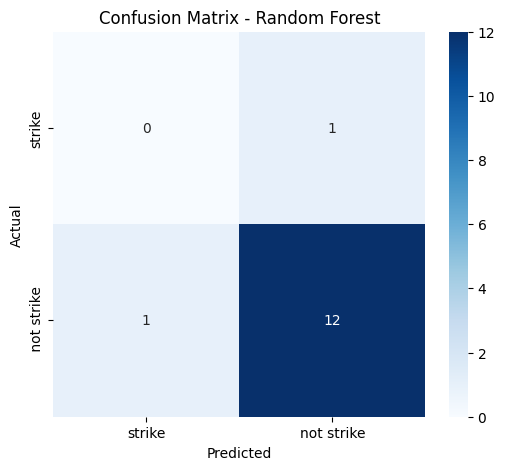

In [126]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 2. train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 3. predict and evaluate
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

# 4. 混淆矩陣圖
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['strike', 'not strike'], yticklabels=['strike', ' not strike'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()
